<a href="https://colab.research.google.com/github/leobioinf0/itacademy/blob/main/M2T01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Usaremos la imagen Docker del repositorio big-data-europe para configurar Hadoop.

```shell
leo@i5hp:~$git clone https://github.com/big-data-europe/docker-hadoop.git
leo@i5hp:~$cd docker-hadoop
```

Con la imagen de Docker para Hadoop en mi máquina local, ejecuto docker-compose para configurar el clúster local de Hadoop. 
Para montar el cluster Hadoop con los "tres datanodes" he utilizado el siguiente docker-compose.yml: 

```yaml
version: "2.1"

services:
  namenode:
    build: ./namenode
    container_name: namenode
    volumes:
      - hadoop_namenode:/hadoop/dfs/name
    environment:
      - CLUSTER_NAME=test
    env_file:
      - ./hadoop.env
    ports:
      - "9870:9870"
  
  resourcemanager:
    build: ./resourcemanager
    container_name: resourcemanager
    restart: on-failure
    depends_on:
      - namenode
      - datanode1
      - datanode2
      - datanode3
    env_file:
      - ./hadoop.env
    ports:
      - "8089:8088"
  
  historyserver:
    build: ./historyserver
    container_name: historyserver
    depends_on:
      - namenode
      - datanode1
      - datanode2
    volumes:
      - hadoop_historyserver:/hadoop/yarn/timeline
    env_file:
      - ./hadoop.env
    ports:
      - "8188:8188"
  
  nodemanager1:
    build: ./nodemanager
    container_name: nodemanager1
    depends_on:
      - namenode
      - datanode1
      - datanode2
    env_file:
      - ./hadoop.env
    ports:
      - "8042:8042"
  
  datanode1:
    build: ./datanode
    container_name: datanode1
    depends_on:
      - namenode
    volumes:
      - hadoop_datanode1:/hadoop/dfs/data
    env_file:
      - ./hadoop.env
  
  datanode2:
    build: ./datanode
    container_name: datanode2
    depends_on:
      - namenode
    volumes:
      - hadoop_datanode2:/hadoop/dfs/data
    env_file:
      - ./hadoop.env
  
  datanode3:
    build: ./datanode
    container_name: datanode3
    depends_on:
      - namenode
    volumes:
      - hadoop_datanode3:/hadoop/dfs/data
    env_file:
      - ./hadoop.env

volumes:
  hadoop_namenode:
  hadoop_datanode1:
  hadoop_datanode2:
  hadoop_datanode3:
  hadoop_historyserver:
```

Este archivo docker-compose configura un clúster de Hadoop con un nodo maestro (namenode) y tres nodos de trabajo, también configura el puerto de red para permitir la comunicación entre los nodos. 

Para iniciar el clúster:

```shell
leo@i5hp:~/docker-hadoop$ sudo docker compose up -d

[+] Running 8/8
 ⠿ Network docker-hadoop_default  Created 0.1s
 ⠿ Container namenode             Started 0.9s
 ⠿ Container datanode3            Started 1.9s
 ⠿ Container datanode1            Started 1.9s
 ⠿ Container datanode2            Started 1.8s
 ⠿ Container nodemanager1         Started 4.0s
 ⠿ Container historyserver        Started 3.3s
 ⠿ Container resourcemanager      Started 4.2s
```

El estado actual del clúster local de Hadoop estará disponible en `localhost:9870`



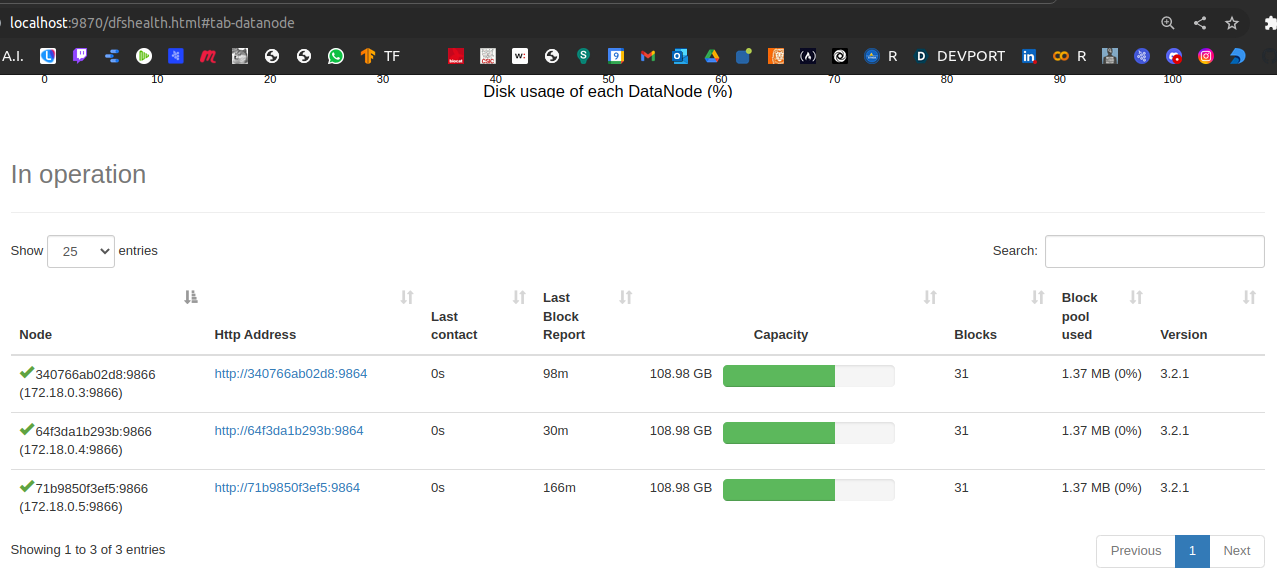

Con `docker container ls` verificar que los contenedores estén activos:



```shell
leo@i5hp:~/docker-hadoop$ sudo docker container ls
CONTAINER ID   IMAGE                           COMMAND                  CREATED         STATUS                   PORTS                                       NAMES
eb1ffdb2da51   docker-hadoop-historyserver     "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   0.0.0.0:8188->8188/tcp, :::8188->8188/tcp   historyserver
68832d605a91   docker-hadoop-resourcemanager   "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   0.0.0.0:8089->8088/tcp, :::8089->8088/tcp   resourcemanager
722cea455d14   docker-hadoop-nodemanager1      "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   0.0.0.0:8042->8042/tcp, :::8042->8042/tcp   nodemanager1
c44e693d1f05   docker-hadoop-datanode3         "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   9864/tcp                                    datanode3
2332723f9214   docker-hadoop-datanode1         "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   9864/tcp                                    datanode1
70b282077659   docker-hadoop-datanode2         "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   9864/tcp                                    datanode2
c1df6be0fc8c   docker-hadoop-namenode          "/entrypoint.sh /run…"   2 minutes ago   Up 2 minutes (healthy)   0.0.0.0:9870->9870/tcp, :::9870->9870/tcp   namenode
```



Para entrar en el container namenode lo ejecutamos en modo interactivo. 

```shell
leo@i5hp:~/docker-hadoop$ sudo docker exec -it namenode /bin/bash
root@32efff4f58f2:/# 

```



Podemos listar el contenido de este nodo. 

```shell
root@89a7710d0ef8:/# hdfs dfs -ls /
Found 1 items
drwxr-xr-x   - root supergroup          0 2023-02-16 19:19 /rmstate
```

# ------------------------------------------

Copiamos el archivo `loremipsum.txt` dentro del container



```shell
leo@i5hp:~/docker-hadoop$ sudo docker cp ~/Downloads/loremipsum.txt namenode:/tmp/
Successfully copied 16.9kB to namenode:/tmp/
```



Descargamos el archivo `hadoop-mapreduce-examples-2.7.1-sources.jar` 

```shell
leo@i5hp:~/docker-hadoop$ wget https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-mapreduce-examples/2.7.1/hadoop-mapreduce-examples-2.7.1-sources.jar
--2023-02-16 20:39:50--  https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-mapreduce-examples/2.7.1/hadoop-mapreduce-examples-2.7.1-sources.jar
Resolving repo1.maven.org (repo1.maven.org)... 151.101.132.209
Connecting to repo1.maven.org (repo1.maven.org)|151.101.132.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 697323 (681K) [application/java-archive]
Saving to: ‘hadoop-mapreduce-examples-2.7.1-sources.jar’

hadoop-mapreduce-examples-2.7.1-sources.jar                     100%[=======================================================================================================================================================>] 680,98K  --.-KB/s    in 0,1s    

2023-02-16 20:39:50 (5,07 MB/s) - ‘hadoop-mapreduce-examples-2.7.1-sources.jar’ saved [697323/697323]
```

y lo copiamos dentro del container

```shell
leo@i5hp:~/docker-hadoop$ sudo docker cp hadoop-mapreduce-examples-2.7.1-sources.jar namenode:/tmp/
Successfully copied 698.9kB to namenode:/tmp/
```

Entramos en el container namenode lo ejecutamos en modo interactivo. 

```shell
leo@i5hp:~/docker-hadoop$ sudo docker exec -it namenode /bin/bash
root@32efff4f58f2:/# 
```

Comprabamos que tanto `loremipsum.txt` como `hadoop-mapreduce-examples-2.7.1-sources.jar` se encuentran en el container dentro del fichero `/tmp/`. 

```shell
root@89a7710d0ef8:/# cd tmp/
root@89a7710d0ef8:/tmp# ls -l
total 712
-rw-rw-r-- 1 1000 1000 697323 Jun 29  2015 hadoop-mapreduce-examples-2.7.1-sources.jar
-rw-r--r-- 1 root root      4 Feb 16 19:18 hadoop-root-namenode.pid
drwxr-xr-x 1 root root   4096 Feb 16 19:26 hsperfdata_root
drwxr-xr-x 2 root root   4096 Feb 16 19:18 jetty-0.0.0.0-9870-hdfs-_-any-2236209138830369355.dir
-rw-rw-r-- 1 1000 1000  15201 Feb  6 07:17 loremipsum.txt
```

Copiamos las primeras 10 líneas de `loremipsum.txt` dentro de un nuevo archivo llamado `loremipsum_10.txt`
```shell
root@89a7710d0ef8:/tmp# head loremipsum.txt > loremipsum_10.txt
```

Creamos la el fichero /leo_madsen/data/input donde pondremos los dos archivos .txt anteriores. 

```shell
root@89a7710d0ef8:/tmp# hdfs dfs -mkdir /leo_madsen/data/input
root@89a7710d0ef8:/tmp# hdfs dfs -put loremipsum.txt /leo_madsen/data/input
2023-02-16 19:56:10,184 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
root@89a7710d0ef8:/tmp# hdfs dfs -put loremipsum_10.txt /leo_madsen/data/input
2023-02-16 19:56:26,819 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
```
Ejecutamos el contador de palabras en hadoop-mapreduce proporcionando `/leo_madsen/data/input/loremipsum_10.txt` como imput y declarando que el resultado lo guarde en el fichero `/leo_madsen/data/output`

```shell
root@89a7710d0ef8:/tmp# hadoop jar hadoop-mapreduce-examples-2.7.1-sources.jar org.apache.hadoop.examples.WordCount /leo_madsen/data/input/loremipsum_10.txt /leo_madsen/data/output
```
Comprobamos que se ha creado el archivo `/leo_madsen/data/output/part-r-00000`
```shell
root@89a7710d0ef8:/tmp# hdfs dfs -ls /leo_madsen/data/output
Found 2 items
-rw-r--r--   3 root supergroup          0 2023-02-16 20:25 /leo_madsen/data/output/_SUCCESS
-rw-r--r--   3 root supergroup       1943 2023-02-16 20:25 /leo_madsen/data/output/part-r-00000
```

Este es el resultado del contador de palabras:
```shell
root@89a7710d0ef8:/tmp# hdfs dfs -cat /leo_madsen/data/output/part-r-00000
2023-02-16 20:29:49,417 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
Accusamus   1
Ad  1
Blandit 1
Brute   1
Consetetur  1
Duis    1
Ea  1
Ei  2
Est 1
```

Copiamos el archivo fuera del cluster

```shell
root@89a7710d0ef8:/tmp# hdfs dfs -copyToLocal /leo_madsen/data/output/part-r-00000
2023-02-16 20:41:48,217 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
```
Ordenamos los datos según la segunda columna y de manera creciente. Del resultado nos quedamos solo con las primeras 10 palabras. El resultado lo guardamos en el archivo `output.txt`

```shell
root@89a7710d0ef8:/tmp# sort -r -k2 -n part-r-00000 | head > output.txt
```

```shell
root@89a7710d0ef8:/tmp# cat output.txt 
ea  4
ut  3
qui 3
ne  3
in  3
ex  3
eum 3
ei  3
dolore  3
```

Repetimos estos mismos pasos pero para el archivo loremipsum.txt

```shell
root@89a7710d0ef8:/tmp# hadoop jar hadoop-mapreduce-examples-2.7.1-sources.jar org.apache.hadoop.examples.WordCount /leo_madsen/data/input/loremipsum.txt /leo_madsen/data/output_fulltext
root@89a7710d0ef8:/tmp# hdfs dfs -copyToLocal /leo_madsen/data/output_fulltext/part-r-00000 part-r-00000_fulltext
oot@89a7710d0ef8:/tmp# sort -r -k2 -n part-r-00000_fulltext |head >output_fulltext.txt
root@89a7710d0ef8:/tmp# cat output_fulltext.txt
et  35
in  26
ei  22
te  21
ne  21
id  21
ea  20
eu  19
at  19
ex  18
```

Finalmente copiamos el fichero del nodo a local y lo comprimimos a un archivo .zip
```shell
root@89a7710d0ef8:/tmp# exit
exit
leo@i5hp:~/docker-hadoop$ sudo docker cp 89a7710d0ef8:/tmp/leo_madsen ./
Preparing to copy...
Copying from container - 32.77kB
Copying from container - 51.71kB
Successfully copied 51.71kB to /home/leo/docker-hadoop/./
```
